# Multivariate Time Series Regression

So far, we have limited our modeling efforts to single time series. RNNs are naturally well suited to multivariate time series and represent a non-linear alternative to the Vector Autoregressive (VAR) models we covered in Chapter 8, Time Series Models. 

## Imports & Settings

In [182]:
import warnings
warnings.filterwarnings('ignore')

In [183]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [184]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [185]:
sns.set_style('whitegrid')
np.random.seed(42)
tf.random.set_seed(42)

In [186]:
results_path = Path('results', 'multivariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Data

For comparison, we illustrate the application of RNNs to modeling and forecasting several time series using the same dataset we used for the VAR example, monthly data on consumer sentiment, and industrial production from the Federal Reserve's FRED service in Chapter 8, Time Series Models:

In [187]:
df = pd.read_csv("/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL_WITH_TWINT_FINBERT_SA.csv", lineterminator='\n', low_memory=False)

df.set_index("date", inplace=True)
# df = sp500[["5. adjusted close"]]

df.sort_values(by=["date"], ascending=True, inplace=True)

df = df[df.index>='2010-01-01']
# df = sp500.copy()
df["adjusted_close_shift"] = df["5. adjusted close"].shift(-1)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               3064 non-null   float64
 1   2. high               3064 non-null   float64
 2   3. low                3064 non-null   float64
 3   4. close              3064 non-null   float64
 4   5. adjusted close     3064 non-null   float64
 5   6. volume             3064 non-null   float64
 6   7. dividend amount    3064 non-null   float64
 7   8. split coefficient  3064 non-null   float64
 8   date_time             3064 non-null   object 
 9   day_of_week           3064 non-null   int64  
 10  adjusted_close_shift  3063 non-null   float64
 11  percentage_change     3064 non-null   float64
 12  increase              3064 non-null   int64  
 13  negative              3064 non-null   float64
 14  nuetral               3064 non-null   float64
 15  positive   

In [189]:
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,adjusted_close_shift,percentage_change,increase,negative,nuetral,positive,retweets
date,,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.543876,17633200.0,0.0,1.0,2010-01-04,0,6.555190,0.172889,1,0.000007,0.000010,0.999984,32.0
2010-01-05,214.60,215.59,213.25,214.38,6.555190,21496600.0,0.0,1.0,2010-01-05,1,6.450921,-1.590633,0,0.498715,0.001116,0.500169,11.0
2010-01-06,214.38,215.23,210.75,210.97,6.450921,19720000.0,0.0,1.0,2010-01-06,2,6.438996,-0.184860,0,0.000052,0.085701,0.914247,6.0
2010-01-07,211.75,212.00,209.05,210.58,6.438996,17040400.0,0.0,1.0,2010-01-07,3,6.481804,0.664830,1,0.457010,0.000224,0.542766,13.0
2010-01-08,210.30,212.00,209.06,211.98,6.481804,15986100.0,0.0,1.0,2010-01-08,4,6.424624,-0.882159,0,0.010157,0.000059,0.989783,19.0


## Prepare Data

### Stationarity

We apply the same transformation—annual difference for both series, prior log-transform for industrial production—to achieve stationarity that we used in Chapter 8 on Time Series Models:

In [190]:
# df_transformed = (pd.DataFrame({'ip': np.log(df.ip).diff(12),
#                                 'sentiment': df.sentiment.diff(12)})
#                   .dropna())

### Scaling

Then we scale the transformed data to the [0,1] interval:

In [191]:
df_transformed = df[["2. high", "3. low", "5. adjusted close", "positive"]]

df_transformed = df_transformed.apply(minmax_scale)
# scaler = MinMaxScaler()
# df_transformed = scaler.fit_transform(df_transformed)  pd.DataFrame(scaled_features, index=df.index, columns=df.columns)  
df_transformed.describe()

,2. high,3. low,5. adjusted close,positive
count,3064.000000,3064.000000,3064.000000,3064.000000
mean,0.280173,0.275689,0.209567,0.752545
std,0.262130,0.258886,0.233957,0.169262
min,0.000000,0.000000,0.000000,0.000000
25%,0.063211,0.061683,0.059199,0.660844
50%,0.168677,0.166210,0.115963,0.765824
75%,0.453326,0.441260,0.242842,0.867454
max,1.000000,1.000000,1.000000,1.000000


### Plot original and transformed series

In [192]:
# fig, axes = plt.subplots(ncols=2, figsize=(14,4))
# columns={'2. high': 'High', '3. low': 'Low', '5. adjusted close': 'adjusted close'}
# df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
# df_transformed.rename(columns=columns).plot(ax=axes[1], title='Tansformed Series')
# sns.despine()
# fig.tight_layout()
# fig.savefig(results_path / 'multi_rnn', dpi=300)

### Reshape data into RNN format

We can reshape directly to get non-overlapping series, i.e., one sample for each year (works only if the number of samples is divisible by window size):

In [193]:
# df.values.reshape(-1, 12, 2).shape

However, we want rolling, not non-overlapping lagged values. The create_multivariate_rnn_data function transforms a dataset of several time series into the shape required by the Keras RNN layers, namely `n_samples` x `window_size` x `n_series`, as follows:

In [194]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

We will use window_size of 24 months and obtain the desired inputs for our RNN model, as follows:

In [195]:
window_size = 63

In [196]:
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)

In [197]:
X.shape, y.shape

((3001, 63, 4), (3001, 4))

In [198]:
df_transformed.head()

,2. high,3. low,5. adjusted close,positive
date,,,,
2010-01-04,0.201507,0.201459,0.003817,0.999985
2010-01-05,0.203281,0.202885,0.003882,0.500169
2010-01-06,0.202695,0.198787,0.003289,0.914248
2010-01-07,0.197438,0.196001,0.003221,0.542766
2010-01-08,0.197438,0.196017,0.003464,0.989785


In [199]:
y.head()

,2. high,3. low,5. adjusted close,positive
date,,,,
2010-04-06,0.243404,0.241813,0.008255,0.666620
2010-04-07,0.246138,0.244534,0.008439,0.514642
2010-04-08,0.245520,0.243517,0.008326,0.999782
2010-04-09,0.246089,0.247484,0.008646,0.999181
2010-04-12,0.248010,0.249697,0.008733,0.999201


In [200]:
type(X)

numpy.ndarray

In [201]:
y = y['5. adjusted close']

In [202]:
type(y)

pandas.core.series.Series

Finally, we split our data into a train and a test set, using the last 24 months to test the out-of-sample performance, as shown here:

In [203]:
# test_size =24
# train_size = X.shape[0]-test_size
train_size = int(len(X) * .9)


In [204]:
X_train, y_train = X[:train_size], y[:train_size]# ['5. adjusted close']
X_test, y_test = X[train_size:], y[train_size:]# ['5. adjusted close']

In [205]:
X_train.shape, X_test.shape

((2700, 63, 4), (301, 63, 4))

In [206]:
y_train.shape, y_test.shape

((2700,), (301,))

## Define Model Architecture

We use a similar architecture with two stacked LSTM layers with 12 and 6 units, respectively, followed by a fully-connected layer with 10 units. The output layer has two units, one for each time series. We compile them using mean absolute loss and the recommended RMSProp optimizer, as follows:

In [207]:
K.clear_session()

In [208]:
n_features = 4
output_size = 1

In [209]:
lstm_units = 63
dense_units = 4

In [210]:
# rnn = Sequential([
#     LSTM(units=lstm_units,
#          # dropout=.1,
#          # recurrent_dropout=.1,
#          input_shape=(window_size, n_features), name='LSTM',
#          return_sequences=False),
#     tf.keras.layers.Dropout(0.20),
#     Dense(dense_units, name='FC'),
#     Dense(output_size, name='Output')
# ])

# rnn = Sequential([
#     Bidirectional(LSTM(units=lstm_units,
#          # dropout=.1,
#          # recurrent_dropout=.1,
#          input_shape=(window_size, n_features), name='LSTM',
#          return_sequences=True)),
#     tf.keras.layers.Dropout(0.20),
#     # Dense(dense_units, name='FC'),
#     Dense(1, name='Output')
# ])

rnn = Sequential([
   #  LSTM(units=63, 
   #       input_shape=(window_size, n_features), name='LSTM'),
   Bidirectional(LSTM(lstm_units, return_sequences=True), name='LSTM1'),
   tf.keras.layers.Dropout(0.20),
# #    LSTM(units=63, 
# #           input_shape=(window_size, n_features), name='LSTM2'),
   Dense(1, name='Output')
])

The model has 1,268 parameters, as shown here:

## Train the Model

We train for 50 epochs with a batch_size value of 20 using early stopping:

In [211]:
lstm_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [212]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                     # learning_rate=lr_schedule,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [213]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

In [214]:
# rnn.compile(loss='mean_absolute_error', optimizer=optimizer)

rnn.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=optimizer,
            metrics=[tf.metrics.MeanAbsoluteError()])

In [215]:
# rnn.summary()

In [216]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=32,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100
85/85 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0542
Epoch 1: val_loss improved from inf to 0.01269, saving model to results/multivariate_time_series/lstm.h5
85/85 [==============================] - 14s 81ms/step - loss: 0.0054 - mean_absolute_error: 0.0542 - val_loss: 0.0127 - val_mean_absolute_error: 0.0827
Epoch 2/100
84/85 [============================>.] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0532
Epoch 2: val_loss improved from 0.01269 to 0.01065, saving model to results/multivariate_time_series/lstm.h5
85/85 [==============================] - 5s 60ms/step - loss: 0.0087 - mean_absolute_error: 0.0532 - val_loss: 0.0107 - val_mean_absolute_error: 0.0747
Epoch 3/100
85/85 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0440
Epoch 3: val_loss improved from 0.01065 to 0.00949, saving model to results/multivariate_time_series/lstm.h5
85/85 [==============================] - 5s 61ms/step 

KeyboardInterrupt: 

## Evaluate the Results

Training stops early after 22 epochs, yielding a test MAE of 1.71, which compares favorably to the test MAE for the VAR model of 1.91.

However, the two results are not fully comparable because the RNN model produces 24 one-step-ahead forecasts, whereas the VAR model uses its own predictions as input for its out-of-sample forecast. You may want to tweak the VAR setup to obtain comparable forecasts and compare their performance:

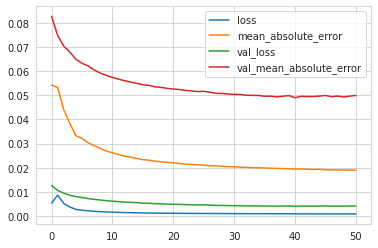

In [ ]:
pd.DataFrame(result.history).plot();

In [ ]:
y_pred = pd.DataFrame(rnn.predict(X_test), 
                      columns=y_test.columns, 
                      index=y_test.index)
y_pred.info()

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
y_pred

NameError: name 'y_pred' is not defined

In [ ]:
test_mae = mean_absolute_error(y_pred, y_test)

NameError: name 'y_pred' is not defined

In [ ]:
print(test_mae)

NameError: name 'test_mae' is not defined

In [ ]:
y_test.index

Index(['2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29', '2020-12-30',
       '2020-12-31', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
       ...
       '2022-02-18', '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25',
       '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04'],
      dtype='object', name='date', length=301)

AttributeError: 'Series' object has no attribute 'columns'

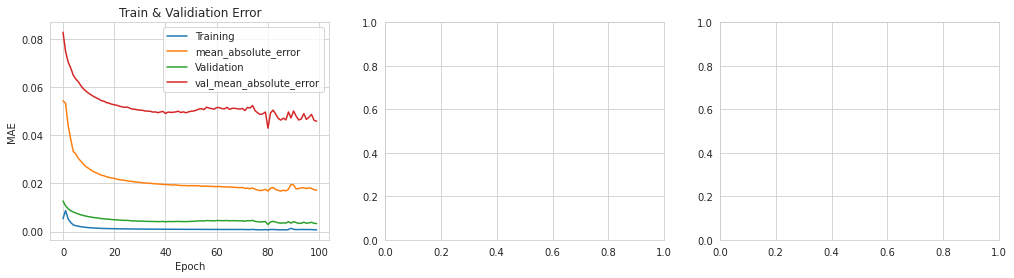

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 4))
pd.DataFrame(result.history).rename(columns={'loss': 'Training',
                                              'val_loss': 'Validation'}).plot(ax=axes[0], title='Train & Validiation Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
# col_dict = {'ip': 'Industrial Production', 'sentiment': 'Sentiment'}
col_dict = {'2. high': 'High', '3. low': 'Low', '5. adjusted close': 'adjusted close'}

for i, col in enumerate(y_test.columns, 1):
    y_train.loc['2010':, col].plot(ax=axes[i], label='training', title=col_dict[col])
    y_test[col].plot(ax=axes[i], label='out-of-sample')
    y_pred[col].plot(ax=axes[i], label='prediction')
    axes[i].set_xlabel('')

axes[1].set_ylim(.5, .9)
axes[1].fill_between(x=y_test.index, y1=0.5, y2=0.9, color='grey', alpha=.5)

axes[2].set_ylim(.3, .9)
axes[2].fill_between(x=y_test.index, y1=0.3, y2=0.9, color='grey', alpha=.5)

plt.legend()
fig.suptitle('Multivariate RNN - Results | Test MAE = {:.4f}'.format(test_mae), fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'multivariate_results', dpi=300);